In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build dataset
block_size = 3  # context length: how many characters do we take to predict the next one?
X,Y = [], []

for w in words:
    # print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append
    
X = torch.tensor(X)
Y = torch.tensor(Y)

In [98]:
# build dataset
def build_dataset(words):
    block_size = 3  # context length: how many characters do we take to predict the next one?
    X,Y = [], []

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27,2))

In [8]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [9]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [10]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [11]:
h

tensor([[-0.7467,  0.9982,  0.2251,  ..., -0.9896,  0.9040, -0.9946],
        [-0.9233,  0.2915,  0.8699,  ..., -0.9598, -0.8363,  0.4034],
        [-0.9904, -0.8517, -0.9890,  ..., -0.3867, -0.8009, -0.9267],
        ...,
        [-0.9492, -0.9171, -0.8807,  ..., -0.9989, -0.9069, -0.0391],
        [-0.9752, -0.4086, -0.9769,  ..., -0.9989, -0.9946, -0.2647],
        [-0.9356, -0.5372, -0.9982,  ..., -0.9964,  0.5504, -0.8858]])

In [12]:
h.shape

torch.Size([228146, 100])

In [13]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [14]:
logits = h @ W2 + b2

In [15]:
logits.shape

torch.Size([228146, 27])

In [16]:
counts = logits.exp()

In [70]:
prob = counts / counts.sum(1, keepdim=True)

In [71]:
prob.shape

torch.Size([32, 27])

In [72]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [76]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.5154)

In [77]:
# ------------ now made respectable :) ---------------

In [99]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [133]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [134]:
for p in parameters:
    p.requires_grad = True

In [135]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [136]:
lri = []
lossi = []
step = []

In [141]:

for i in range(50000):

    # minibatch construc
    ix = torch.randint(0,Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
    logits = h@ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits,Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    step.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())

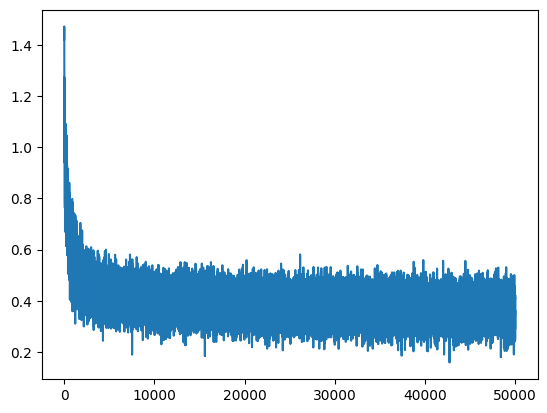

In [138]:
plt.plot(step, lossi)

In [112]:
print(loss.item())

2.3375205993652344


In [142]:
emb = C[Xtr] # 32, 3, 2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
logits = h@ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.1883, grad_fn=<NllLossBackward0>)

In [143]:
emb = C[Xdev] # 32, 3, 2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
logits = h@ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.2099, grad_fn=<NllLossBackward0>)

In [129]:
C.shape

torch.Size([27, 2])

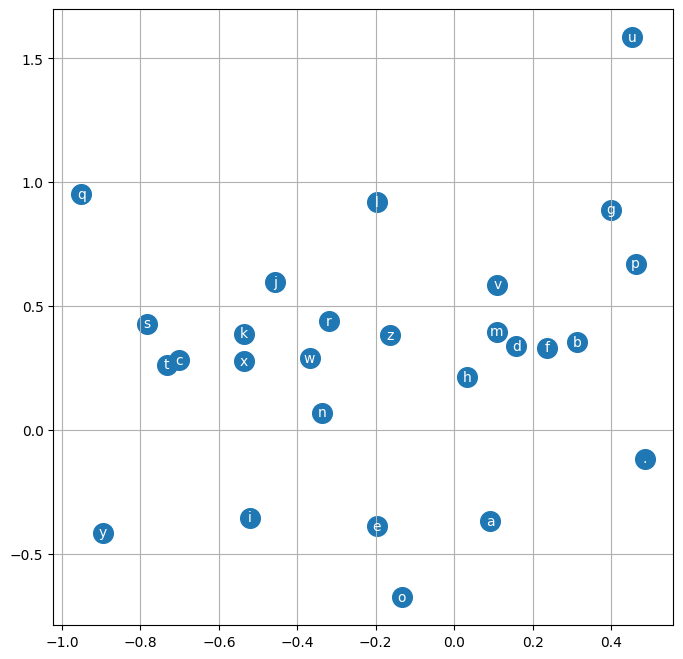

In [132]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i],ha='center',va='center',color='white')
plt.grid("minor")

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [144]:
context = [0]*block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [146]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0]*block_size # initializ with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h@ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


mria.
mayah.
see.
med.
ryah.
rethan.
endra.
gradeerdielin.
shi.
jenleigh.
samanar.
kayziohlara.
noshibergihianest.
juli.
jenilanthana.
uburted.
ruyah.
fael.
yumajahsanyah.
hil.


In [145]:
W1.shape

torch.Size([30, 200])